# Tarea 3

## Esteban Reyes Saldaña

### Minería de Texto Básica

## Funciones Generales

In [1]:
# Librerías
import os
import re
import math
import itertools
import numpy as np
import time as time
from keras.preprocessing.text import Tokenizer

In [2]:
def get_texts_from_file (path_corpus, path_truth) :
  tr_txt = []
  tr_y   = []

  with open (path_corpus, "r") as f_corpus, open(path_truth, "r", encoding='utf-8') as f_truth:
    for twitt in f_corpus:
      tr_txt += [twitt]
    for label in f_truth:
      tr_y   += [label]
  
  tr_y = list(map(int, tr_y))

  return tr_txt, tr_y

In [5]:
# Ruta para leer desde drive
dir = '../Data/'

In [6]:
tr_txt, tr_y = get_texts_from_file(dir + '/mex_train.txt', dir + '/mex_train_labels.txt')

In [7]:
# Conjunto de validación
val_txt, val_y = get_texts_from_file(dir + '/mex_val.txt', dir + '/mex_val_labels.txt')

In [8]:
import nltk 
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

In [9]:
corpus_palabras = []
for doc in tr_txt :
  corpus_palabras += tokenizer.tokenize(doc)

fdist = nltk.FreqDist(corpus_palabras)

In [10]:
# Ordenar  diccionario
def sortfreqDict(freqdict):
  aux = [(freqdict[key], key) for key in freqdict]
  aux.sort(key = lambda elem: (elem[0], elem[1]), reverse = True)
  return aux

In [11]:
# Recorto vocabulario a 5000 más frecuentes
V = sortfreqDict(fdist)
V = V[:5000]

In [12]:
# Creo diccionario de vocabulario
dict_indices = dict()
count = 0

for wigth, word in V:
  dict_indices[word] = count
  count += 1

## BoW

In [13]:
def build_bow_tr(tr_txt, V, dict_indices):
  BOW = np.zeros((len(tr_txt), len(V)), dtype = int)

  cont_doc = 0
  for tr in tr_txt:
    fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))

    for word in fdist_doc:
      if word in dict_indices:
        BOW[cont_doc, dict_indices[word]] = 1
    
    cont_doc += 1
  return BOW

In [14]:
BOW_tr = build_bow_tr(tr_txt, V, dict_indices)
print(BOW_tr.shape)

(5544, 5000)


## BoW con pesado tfidf

In [15]:
def get_freq_term_documents(tr_txt, dict_indices,  emotions = False, word_emotions = {}): 
  # Creo diccionario
  dict_word_doc = dict()
  # Lo lleno con valores cero
  for tr in tr_txt :
    tokens = tokenizer.tokenize(tr)
    if emotions :
      tokens = mask_emotion(tokens, word_emotions)

    fdist_doc = nltk.FreqDist(tokens)
    for word in fdist_doc:
      if word in dict_indices :
        if fdist_doc[word] > 0:
          dict_word_doc[word] = 0
  # Lleno diccionario con valor termino en documentos
  for tr in tr_txt :
    tokens = tokenizer.tokenize(tr)
    if emotions :
      tokens = mask_emotion(tokens, word_emotions)
      
    fdist_doc = nltk.FreqDist(tokens)
    for word in fdist_doc:
      if word in dict_indices :
        if fdist_doc[word] > 0:
          dict_word_doc[word] += 1
  return dict_word_doc

In [16]:
def build_bow_tfidf(tr_txt, V, dict_indices, normalized = None, emotions = False, word_emotions = {}, probabilities = False, dict_prob = {}):
  '''
  Construye bolsa de pesado TFIDF
  Parámetros
  -----------
    tr_txt        : Texto en string
    dict_indices  : Diccionario de palabras ordenadas por frecuencia
    normalized    : Bool para normalizar BoW por filas
    emotions      : Bool para detertar si se debe enmascarar por emociones
    word_emotions : Diccionario de máscaras
  Regresa
  -----------
    BoW           : Bolsa de palabras
  '''
  BOW = np.zeros((len(tr_txt), len(V)), dtype = np.float)

  cont_doc = 0
  
  # Tamaño del vocabulario
  N = len(V)

  # Cargo frecuencias termino documentos
  dict_word_doc = get_freq_term_documents(tr_txt, dict_indices, emotions = emotions, word_emotions = word_emotions)
 
  for tr in tr_txt:
    # Creo conjunto de frencuencias
    tokens = tokenizer.tokenize(tr)
    if emotions :
      tokens = mask_emotion(tokens, word_emotions)
    fdist_doc = nltk.FreqDist(tokens)

    for word in fdist_doc:
      if word in dict_indices:
        BOW[cont_doc, dict_indices[word]] = fdist_doc[word] * math.log10(N / (dict_word_doc[word] + 1) )
        if probabilities :
          if word in dict_prob :
            BOW[cont_doc, dict_indices[word]] *= dict_prob[word] 
    cont_doc += 1

  if (normalized) :
    n = np.linalg.norm(BOW,  ord = None)
    BOW = BOW/n
  return BOW

# Clasificación con SVM

In [17]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support, roc_auc_score

In [18]:
def svm_classification(BoW_tr, tr_y, BoW_val, tr_val) :
  parameters = {'C':[.05, .12, .25, .5, 1, 2, 4]}
 
  svr = svm.LinearSVC(class_weight = 'balanced')
  grid = GridSearchCV(estimator = svr, param_grid = parameters, n_jobs = 8, scoring= "f1_macro", cv = 5)
 
  grid.fit(BoW_tr, tr_y)
 
  y_pred = grid.predict(BoW_val)
 
  p, r, f, s = precision_recall_fscore_support(val_y, y_pred, average = 'macro', pos_label = 1) 
 
  print(confusion_matrix(val_y, y_pred))
  print(metrics.classification_report(val_y, y_pred))
 
  return [p, r, f]

In [19]:
from sklearn.feature_selection import SelectKBest, chi2

feats = SelectKBest(chi2, k = 1000)
feats.fit(BOW_tr, tr_y)

best = feats.get_support(indices = True)

## Gráficas

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline 
from nltk.corpus import stopwords
nltk.download('stopwords')
sw = set(stopwords.words("spanish"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/giovanni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
def grafica_constelacion(reduced_matrix, max_x, max_y, t_words) :
  plt.figure(figsize = (40,40), dpi = 100); plt.xlim((-max_x, max_x)); plt.ylim((-max_y, max_y));
  plt.scatter(reduced_matrix[:,0], reduced_matrix[:, 1], 20, color = 'black');

  for idx, word in enumerate(t_words[:]):
    x = reduced_matrix[idx, 0]
    y = reduced_matrix[idx, 1]
    if word in sw:
      plt.annotate(word, (x,y), color = 'red')
    else:
      plt.annotate(word, (x,y), color = 'black')

def grafica_centroide(reduced_matrix, t_words, subsetwords) :
  ploted_subsetwords = []
  subreduced_matrix  = []
  for idx, word in enumerate(t_words[:]) :
    if word in subsetwords:
      ploted_subsetwords += [word]
      subreduced_matrix += [reduced_matrix[idx]]

  subreduced_matrix = np.array(subreduced_matrix)

  fig , ax = plt.subplots(figsize = (15, 15))

  col1 = 0
  col2 = 1

  for word in subreduced_matrix:
    ax.arrow(0, 0, word[col1], word[col2], head_width = 0.8, head_length = 0.8, fc = 'r', ec = 'r', width = 1e-2)

  ax.scatter(subreduced_matrix[:,col1], subreduced_matrix[:, col2])

  for i in range(0, len(ploted_subsetwords)):
    ax.annotate(ploted_subsetwords[i], (subreduced_matrix[i,col1], subreduced_matrix[i, col2]))

  plt.show()

In [ ]:
# Cargo tsne manualmente desde drive
from importlib.machinery import SourceFileLoader
somemodule = SourceFileLoader('tsne', dir + '/tsne.py').load_module()
import tsne as tsne

# 1.2 Selección de Términos y DTRs

1. Programe y visualiza TCOR. Puede hacer esto de forma similar a como el profesor lo hizo en el Lecture 9 con DOR. Al menos dos gráficas, la de constelación de palabras y subconjunto con centroide.

## TCOR

In [22]:
def compute_tcor(tr_txt, V, dict_indices, weight = 'short-text') :
  T = len(V)
  tcor_matrix = np.zeros((T, T), dtype=np.float)
  T_k = np.zeros(T, dtype=np.float)
  T = float(T)
  # Obtengo conjunto de tokens por documento
  sets = [set(tokenizer.tokenize(doc)) for doc in tr_txt]
  # Quito palabras que no están en vocabulario
  for myset in sets :
    tmp = myset.copy()
    for word in tmp :
      if word not in dict_indices:
        myset.remove(word)
  # --------------------------------------------------------
  for subset in sets :
      for word in subset :
        # Coocurrencia de palabra consigo mismas
        tcor_matrix[dict_indices[word]][dict_indices[word]] += 1.0
      for result in itertools.combinations(subset, 2):
        if result[0] in dict_indices and result[1] in dict_indices :
          tcor_matrix[dict_indices[result[0]]][dict_indices[result[1]]] += 1.0
          tcor_matrix[dict_indices[result[1]]][dict_indices[result[0]]] += 1.0

  if weight == 'short-text' :
    for k in range(int(T)):
      T_k[k] = np.sum(tcor_matrix[k] > 0) 
      for j in range(int(T)) :
        tk_tj = tcor_matrix[k][j]
        if tk_tj >0:
          tcor_matrix[k][j] = (1.0 + math.log10(tk_tj)) * math.log10(T/ T_k[k])
  if weight == 'PPMI' :
    aux = np.zeros((int(T), int(T)), dtype=np.float)
    count_w       = np.sum(tcor_matrix, axis = 1)
    count_context = np.sum(tcor_matrix, axis = 0)
    total         = np.sum(count_w)
    for k in range(tcor_matrix.shape[0]) :
      for j in range(tcor_matrix.shape[1]) :
        if tcor_matrix[k][j] > 0 :
          p_wk_wj = tcor_matrix[k][j] / total
          p_wk    = count_w[k] / total
          p_wj    = count_context[j] / total
          if abs(p_wk * p_wj) > 0 :
            tcor_matrix[k][j] = max(math.log2(p_wk_wj/ (p_wk * p_wj)), 0)
  return tcor_matrix

In [23]:
star = time.time()
tcor_matrix = compute_tcor(tr_txt, V, dict_indices, weight='short-text')
print('time: ', time.time() - star, 'segundos.')

<ipython-input-22-bd32f1e7a2b5>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tcor_matrix = np.zeros((T, T), dtype=np.float)
<ipython-input-22-bd32f1e7a2b5>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_k = np.zeros(T, dtype=np.float)


time:  15.824753284454346 segundos.


In [29]:
dict_indices

{'que': 0,
 'de': 1,
 '.': 2,
 'a': 3,
 'la': 4,
 'y': 5,
 'no': 6,
 'me': 7,
 '!': 8,
 'el': 9,
 '@usuario': 10,
 'en': 11,
 'verga': 12,
 'madre': 13,
 'se': 14,
 'putas': 15,
 'los': 16,
 'es': 17,
 'putos': 18,
 '?': 19,
 'con': 20,
 'por': 21,
 'mi': 22,
 'un': 23,
 'te': 24,
 'ya': 25,
 'si': 26,
 '"': 27,
 'lo': 28,
 'las': 29,
 'como': 30,
 'para': 31,
 'loca': 32,
 'su': 33,
 'tu': 34,
 'una': 35,
 '...': 36,
 'pero': 37,
 'le': 38,
 '😂': 39,
 'al': 40,
 'del': 41,
 'más': 42,
 'yo': 43,
 'pinche': 44,
 'cuando': 45,
 'puta': 46,
 'qué': 47,
 'todos': 48,
 'o': 49,
 ':': 50,
 'bien': 51,
 'son': 52,
 'estoy': 53,
 '¿': 54,
 'les': 55,
 'hdp': 56,
 'porque': 57,
 'sus': 58,
 'todo': 59,
 'joto': 60,
 'ni': 61,
 'hasta': 62,
 'esta': 63,
 'está': 64,
 '…': 65,
 'marica': 66,
 'ser': 67,
 'q': 68,
 'así': 69,
 'soy': 70,
 'vale': 71,
 'hay': 72,
 'puto': 73,
 'eso': 74,
 'pinches': 75,
 'voy': 76,
 'mis': 77,
 'ver': 78,
 'este': 79,
 'quiero': 80,
 'solo': 81,
 'luchona': 82,
 '

In [25]:
from pprint import pprint
pprint(tcor_matrix)

array([[0.37848588, 0.34999819, 0.3442461 , ..., 0.        , 0.08608024,
        0.        ],
       [0.25527317, 0.27680558, 0.25220184, ..., 0.        , 0.        ,
        0.06278311],
       [0.4589078 , 0.46096218, 0.49569725, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 3.09691001, 0.        ,
        0.        ],
       [2.49485002, 0.        , 0.        , ..., 0.        , 2.49485002,
        0.        ],
       [0.        , 2.39794001, 0.        , ..., 0.        , 0.        ,
        2.39794001]])


## Selección de Palabras

In [ ]:
from sklearn import preprocessing
TCOR_base = preprocessing.normalize(tcor_matrix, norm = 'l2')

In [ ]:
TCOR_base

array([[0.0454991 , 0.04207449, 0.04138302, ..., 0.        , 0.        ,
        0.010348  ],
       [0.04107599, 0.04454077, 0.04058179, ..., 0.01010243, 0.        ,
        0.01010243],
       [0.0440105 , 0.04420752, 0.04753871, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.26726124, 0.        , ..., 0.26726124, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.30151134,
        0.        ],
       [0.20412415, 0.20412415, 0.        , ..., 0.        , 0.        ,
        0.20412415]])

In [ ]:
dict_indice_invertido = {}
for w in dict_indices:
  dict_indice_invertido[dict_indices[w]] = w

target_words = [dict_indice_invertido[index] for index in best]
t_words = target_words

target_matrix = np.array([TCOR_base[dict_indices[word]] for word in t_words])


In [ ]:
target_matrix.shape

(1000, 5000)

In [ ]:
from tsne import tsne
reduced_matrix = tsne(target_matrix, 2)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 0.161116
Iteration 10: error is 17.861252
Iteration 20: error is 17.560008
Iteration 30: error is 17.436608
Iteration 40: error is 17.436896
Iteration 50: error is 17.392357
Iteration 60: error is 17.487092
Iteration 70: error is 17.451808
Iteration 80: error is 17.396604
Iteration 90: error is 17.475766
Iteration 100: error is 17.491353
Iteration 110: error is 2.277726
Iteration 120: error is 1.884020
Iteration 130: error is 1.737133
Iteration 140: error is 1.643330
Iteration 150: error is 1.588170
Iteration 160: error is 1.551666
Iteration 170: error is 1.524885
Iteration 180: error is 1.503870
Iteration 190: error is 1.486912
Iteration 200: error is 1.472810
Iteration 210: error is 1.461367
Iteration 220: error is 1.451729
Iteration 230: error is 1.443717
Iteration 240: error is 1.436798
Iteration 250: error is

In [ ]:
max_x = np.amax(reduced_matrix, axis = 0)[0]
max_y = np.amax(reduced_matrix, axis = 0)[1]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128405 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128405 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129300 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129318 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129318 missing from current font.
  font.se

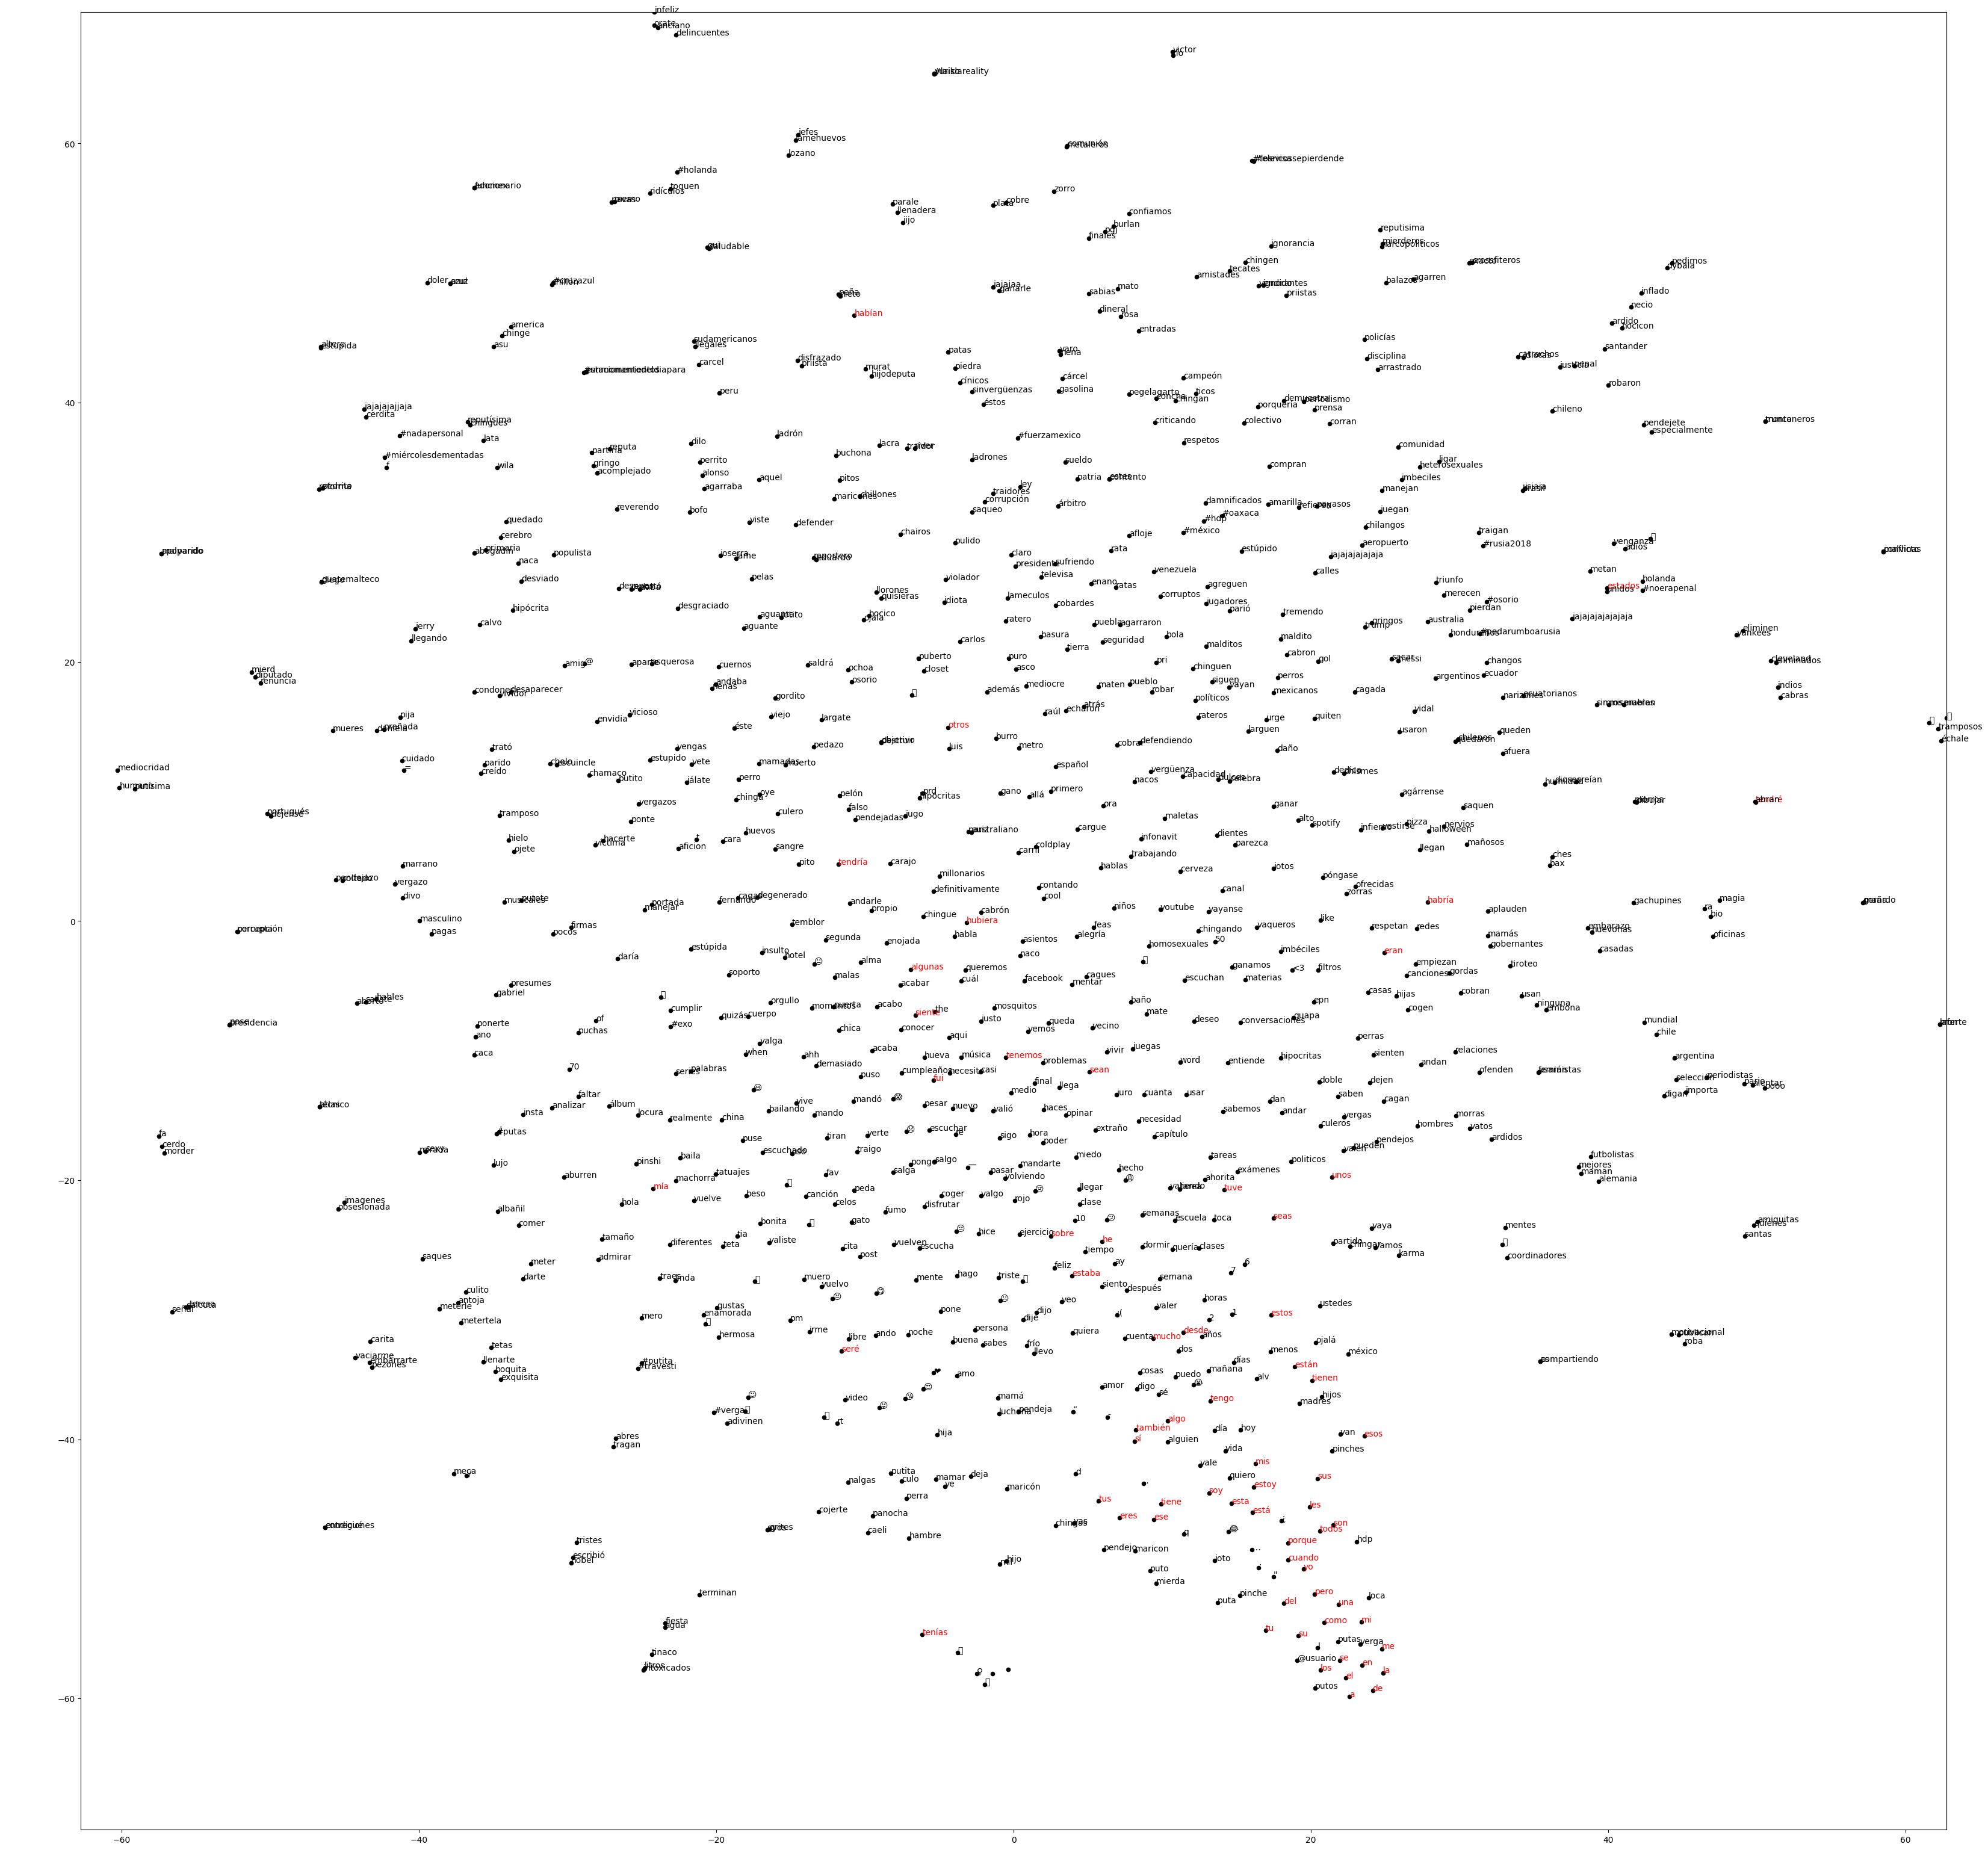

In [ ]:
grafica_constelacion(reduced_matrix, max_x, max_y, t_words)

In [ ]:
subsetwords = ["tristes", "triste", "alegría", "hermosa", "chica", "hombres", "hdp", "madre","madres", "@usuario", "hijos", "pendeja", "pendejo", "mierda", "loca", "hijo", "hija", "mamá", "tía" ]

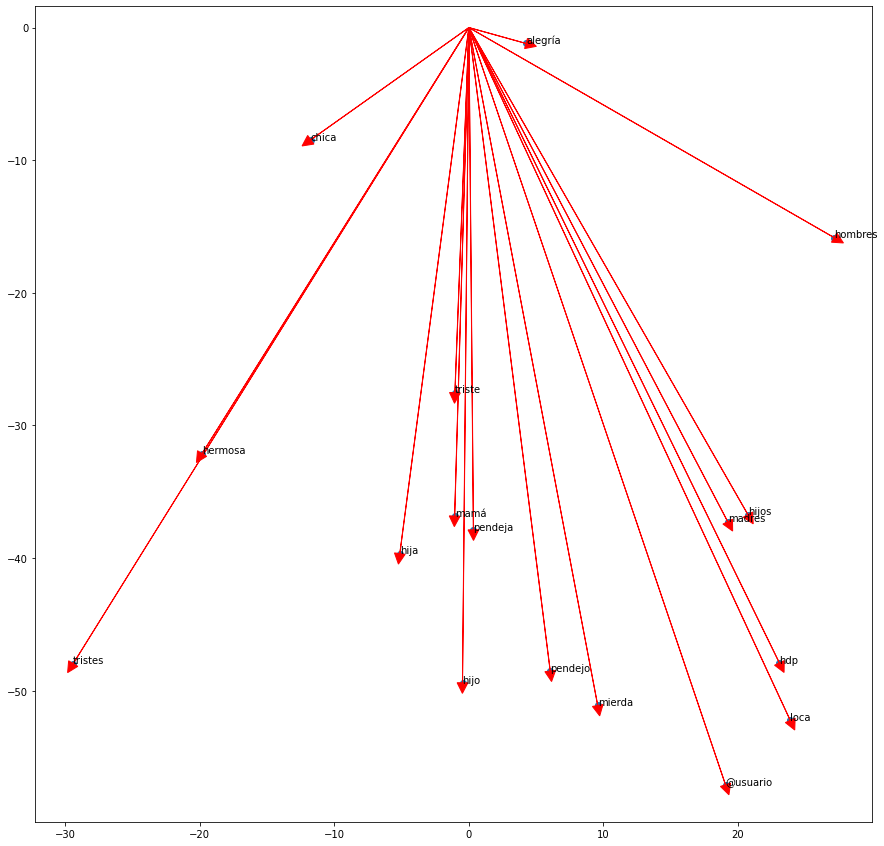

In [ ]:
grafica_centroide(reduced_matrix, t_words, subsetwords)

2. Programe y visualiza TCOR, pero en lugar de hacer el pesado del Lecture 6, haga PPMI como sugiere Dan Jurafsky Discuta en un parráfo sus observaciones. Al menos dos gráficas, la de constelación de palabras y subconjunto con centroide.

In [ ]:
star = time.time()
tcor_matrix_PPMI = compute_tcor(tr_txt, V, dict_indices, weight ='PPMI')
print('time: ', time.time() - star, 'segundos.')

time:  18.64580750465393 segundos.


In [ ]:
tcor_matrix_PPMI

array([[ 1.01007071,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.47813591],
       [ 0.        ,  1.04040307,  0.03473474, ...,  1.25094227,
         0.        ,  0.47333469],
       [ 0.        ,  0.03473474,  1.33641733, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  1.25094227,  0.        , ..., 12.78566201,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        13.48150862,  0.        ],
       [ 0.47813591,  0.47333469,  0.        , ...,  0.        ,
         0.        , 11.23044686]])

In [ ]:
TCOR_base = preprocessing.normalize(tcor_matrix_PPMI, norm = 'l2')

In [ ]:
TCOR_base

array([[0.03609861, 0.        , 0.        , ..., 0.        , 0.        ,
        0.01708796],
       [0.        , 0.03186351, 0.00106379, ..., 0.03831151, 0.        ,
        0.0144964 ],
       [0.        , 0.00101446, 0.03903141, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.05004794, 0.        , ..., 0.51153119, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.48049412,
        0.        ],
       [0.01515391, 0.01500174, 0.        , ..., 0.        , 0.        ,
        0.35593479]])

In [ ]:
dict_indice_invertido = {}
for w in dict_indices:
  dict_indice_invertido[dict_indices[w]] = w

target_words = [dict_indice_invertido[index] for index in best]
t_words = target_words

target_matrix = np.array([TCOR_base[dict_indices[word]] for word in t_words])

In [ ]:
target_matrix.shape

(1000, 5000)

In [ ]:
from tsne import tsne 
reduced_matrix = tsne(target_matrix, 2)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 0.151301
Iteration 10: error is 17.865046
Iteration 20: error is 17.625551
Iteration 30: error is 17.549111
Iteration 40: error is 17.537903
Iteration 50: error is 17.556382
Iteration 60: error is 17.536583
Iteration 70: error is 17.503226
Iteration 80: error is 17.583846
Iteration 90: error is 17.599852
Iteration 100: error is 17.617834
Iteration 110: error is 2.224797
Iteration 120: error is 1.746532
Iteration 130: error is 1.557127
Iteration 140: error is 1.442388
Iteration 150: error is 1.342336
Iteration 160: error is 1.295910
Iteration 170: error is 1.262705
Iteration 180: error is 1.236866
Iteration 190: error is 1.216282
Iteration 200: error is 1.199552
Iteration 210: error is 1.186033
Iteration 220: error is 1.174821
Iteration 230: error is 1.165643
Iteration 240: error is 1.157863
Iteration 250: error is

In [ ]:
max_x = np.amax(reduced_matrix, axis = 0)[0]
max_y = np.amax(reduced_matrix, axis = 0)[1]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128405 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128405 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129300 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129318 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129318 missing from current font.
  font.se

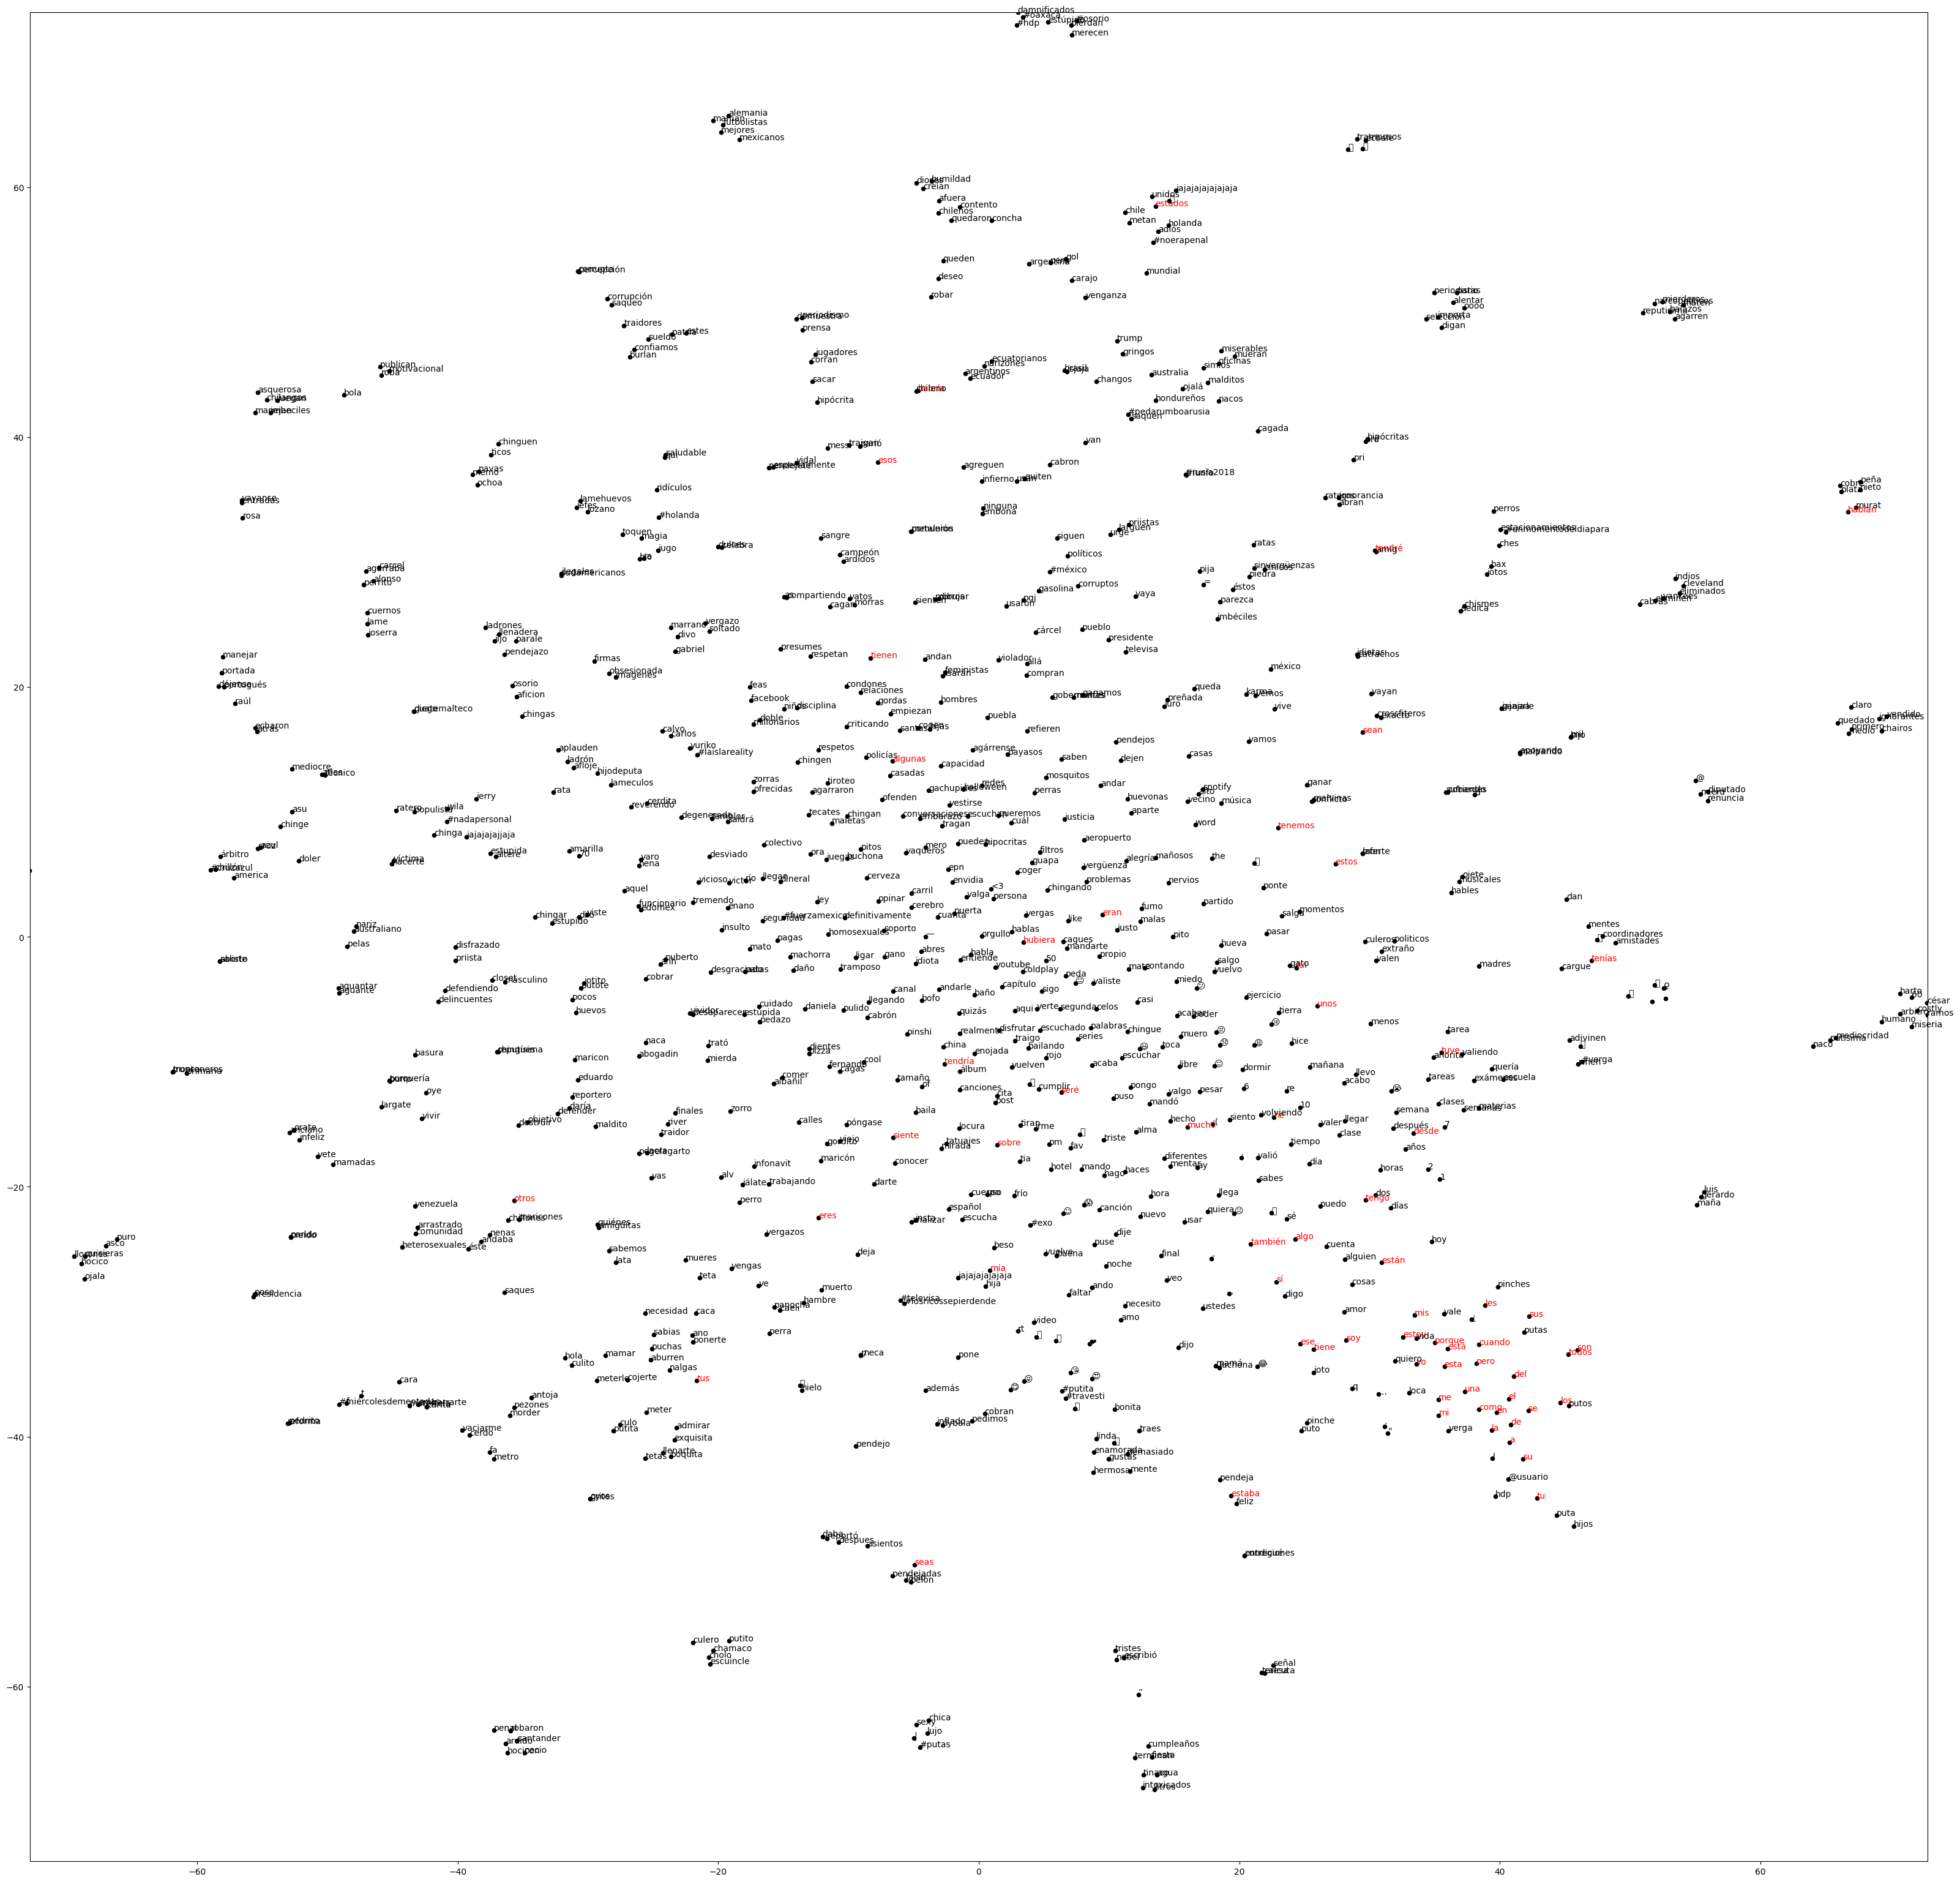

In [ ]:
grafica_constelacion(reduced_matrix, max_x, max_y, t_words)

In [ ]:
subsetwords = ["tristes", "triste", "alegría", "hermosa", "chica", "hombres", "hdp", "madre","madres", "@usuario", "hijos", "pendeja", "pendejo", "mierda", "loca", "hijo", "hija", "mamá", "tía" ]

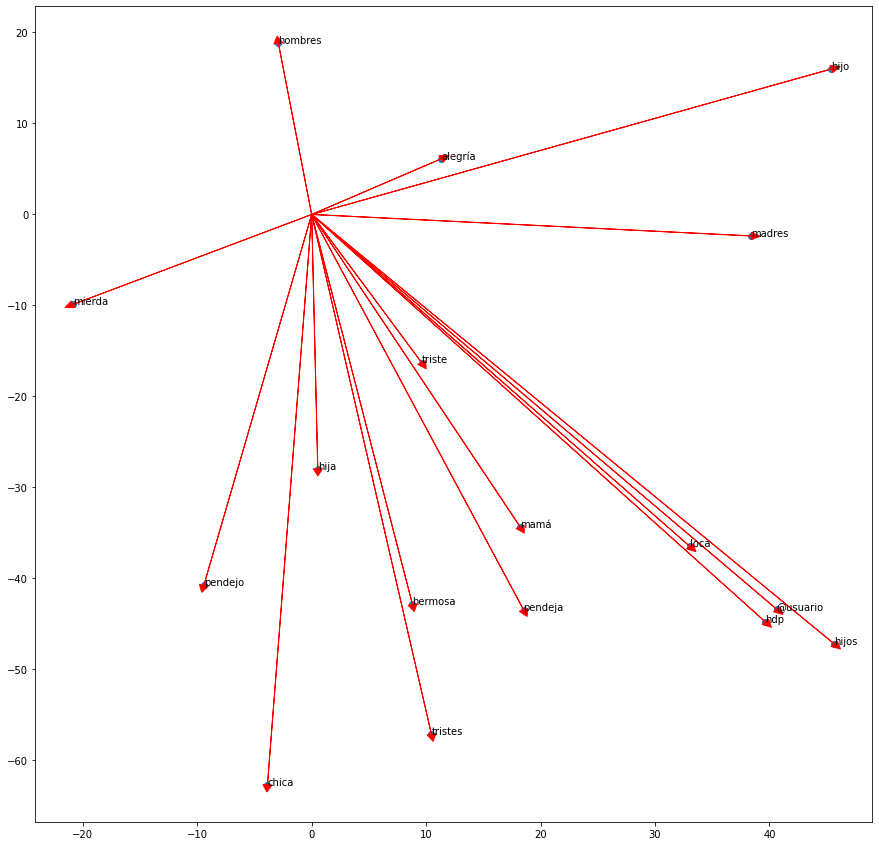

In [ ]:
grafica_centroide(reduced_matrix, t_words, subsetwords)

## Observaciones

Esta forma de pesar la información usa la probabilidad de observar la coocurrencia de dos palabras dada la información del corpus. Se observó que los pesos para las coocurrencias con menor frecuencia son pesadas más grandes en comparación a tf-itf. Además, el error obtenido hacia el final en PCA es menor al de if-iif por 0.3, sus gráficas de constelación son muy similares (pareciera que se rotaron), al igual que sus gráficas de centroide) y se observa una ligera agrupación de las stopwords.

3. Programe y visualiza Random Indexing, Puede hacer esto de forma similar a como el profesor lo hizo en el Lecture 9 con DOR. Al menos dos gráficas, la de constelación de palabras y subconjunto con centroide.

In [ ]:
def random_indexing (tr_txt, V, dict_indices, size = 300) :
  sets = [tokenizer.tokenize(doc) for doc in tr_txt]
  # Matrix de coocurrencias
  coocurence = np.zeros((len(V), len(V)), dtype=np.float)
  for subset in sets :
    for word in subset :
      # Coocurrencia de palabra consigo mismas
      if word in dict_indices :
        coocurence[dict_indices[word]][dict_indices[word]] += 1.0
      for result in itertools.combinations(subset, 2):
        if result[0] in dict_indices and result[1] in dict_indices :
          coocurence[dict_indices[result[0]]][dict_indices[result[1]]] += 1.0
          coocurence[dict_indices[result[1]]][dict_indices[result[0]]] += 1.0
  # -------------------------------------------------------------------------
  # Matriz de 0, -1, 1
  id_matrix = np.zeros((len(V), size), dtype= np.float) 
  # Representación random Indexing
  ri_matrix = np.zeros((len(V), size), dtype = np.float)

  # Asigno aleatoriamente -1 y 1 al 5% de los datos
  nonzero = round(0.02 * size)
  for i in range(len(V)):
    values = np.random.choice([-1,1], size = nonzero)
    positions = np.random.randint(0,size, size = nonzero)
    for j in range(nonzero) :
      id_matrix[i][positions[j]] = values[j]

  # Obtengo Regresentación RI
  for k in range(len(V)) :
    nonzeropositions = np.nonzero(coocurence[k])[0]
    for id in nonzeropositions :
      ri_matrix[k] += coocurence[k][id] * id_matrix[id]
  
  return ri_matrix


In [ ]:
ri_matrix = random_indexing(tr_txt, V, dict_indices, size = 500)

In [ ]:
ri_matrix.shape

(5000, 500)

## Selección de Palabras

In [ ]:
TCOR_base = preprocessing.normalize(ri_matrix, norm = 'l2')

In [ ]:
TCOR_base

array([[-0.05962997, -0.00721206,  0.00173501, ..., -0.00057099,
         0.03474678,  0.01638458],
       [-0.05570961, -0.01118448,  0.00157585, ..., -0.00874125,
         0.03660548,  0.02117025],
       [-0.0660778 , -0.00649845,  0.00492147, ..., -0.00455214,
         0.03316054,  0.01777766],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.00640578,  0.        ],
       [ 0.08693644,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.05447263, ...,  0.        ,
        -0.05447263,  0.        ]])

In [ ]:
dict_indice_invertido = {}
for w in dict_indices:
  dict_indice_invertido[dict_indices[w]] = w

target_words = [dict_indice_invertido[index] for index in best]
t_words = target_words

target_matrix = np.array([TCOR_base[dict_indices[word]] for word in t_words])


In [ ]:
target_matrix.shape

(1000, 500)

In [ ]:
reduced_matrix = tsne(target_matrix, 2)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 0.210867
Iteration 10: error is 17.874314
Iteration 20: error is 17.669909
Iteration 30: error is 17.429718
Iteration 40: error is 17.473487
Iteration 50: error is 17.465547
Iteration 60: error is 17.473368
Iteration 70: error is 17.448139
Iteration 80: error is 17.455261
Iteration 90: error is 17.456010
Iteration 100: error is 17.442545
Iteration 110: error is 2.241737
Iteration 120: error is 1.875608
Iteration 130: error is 1.749352
Iteration 140: error is 1.677268
Iteration 150: error is 1.629270
Iteration 160: error is 1.595401
Iteration 170: error is 1.570316
Iteration 180: error is 1.550242
Iteration 190: error is 1.533529
Iteration 200: error is 1.519930
Iteration 210: error is 1.508981
Iteration 220: error is 1.499746
Iteration 230: error is 1.491931
Iteration 240: error is 1.485314
Iteration 250: error is

In [ ]:
max_x = np.amax(reduced_matrix, axis = 0)[0]
max_y = np.amax(reduced_matrix, axis = 0)[1]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129300 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129318 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129318 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127814 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127814 missing from current font.
  font.se

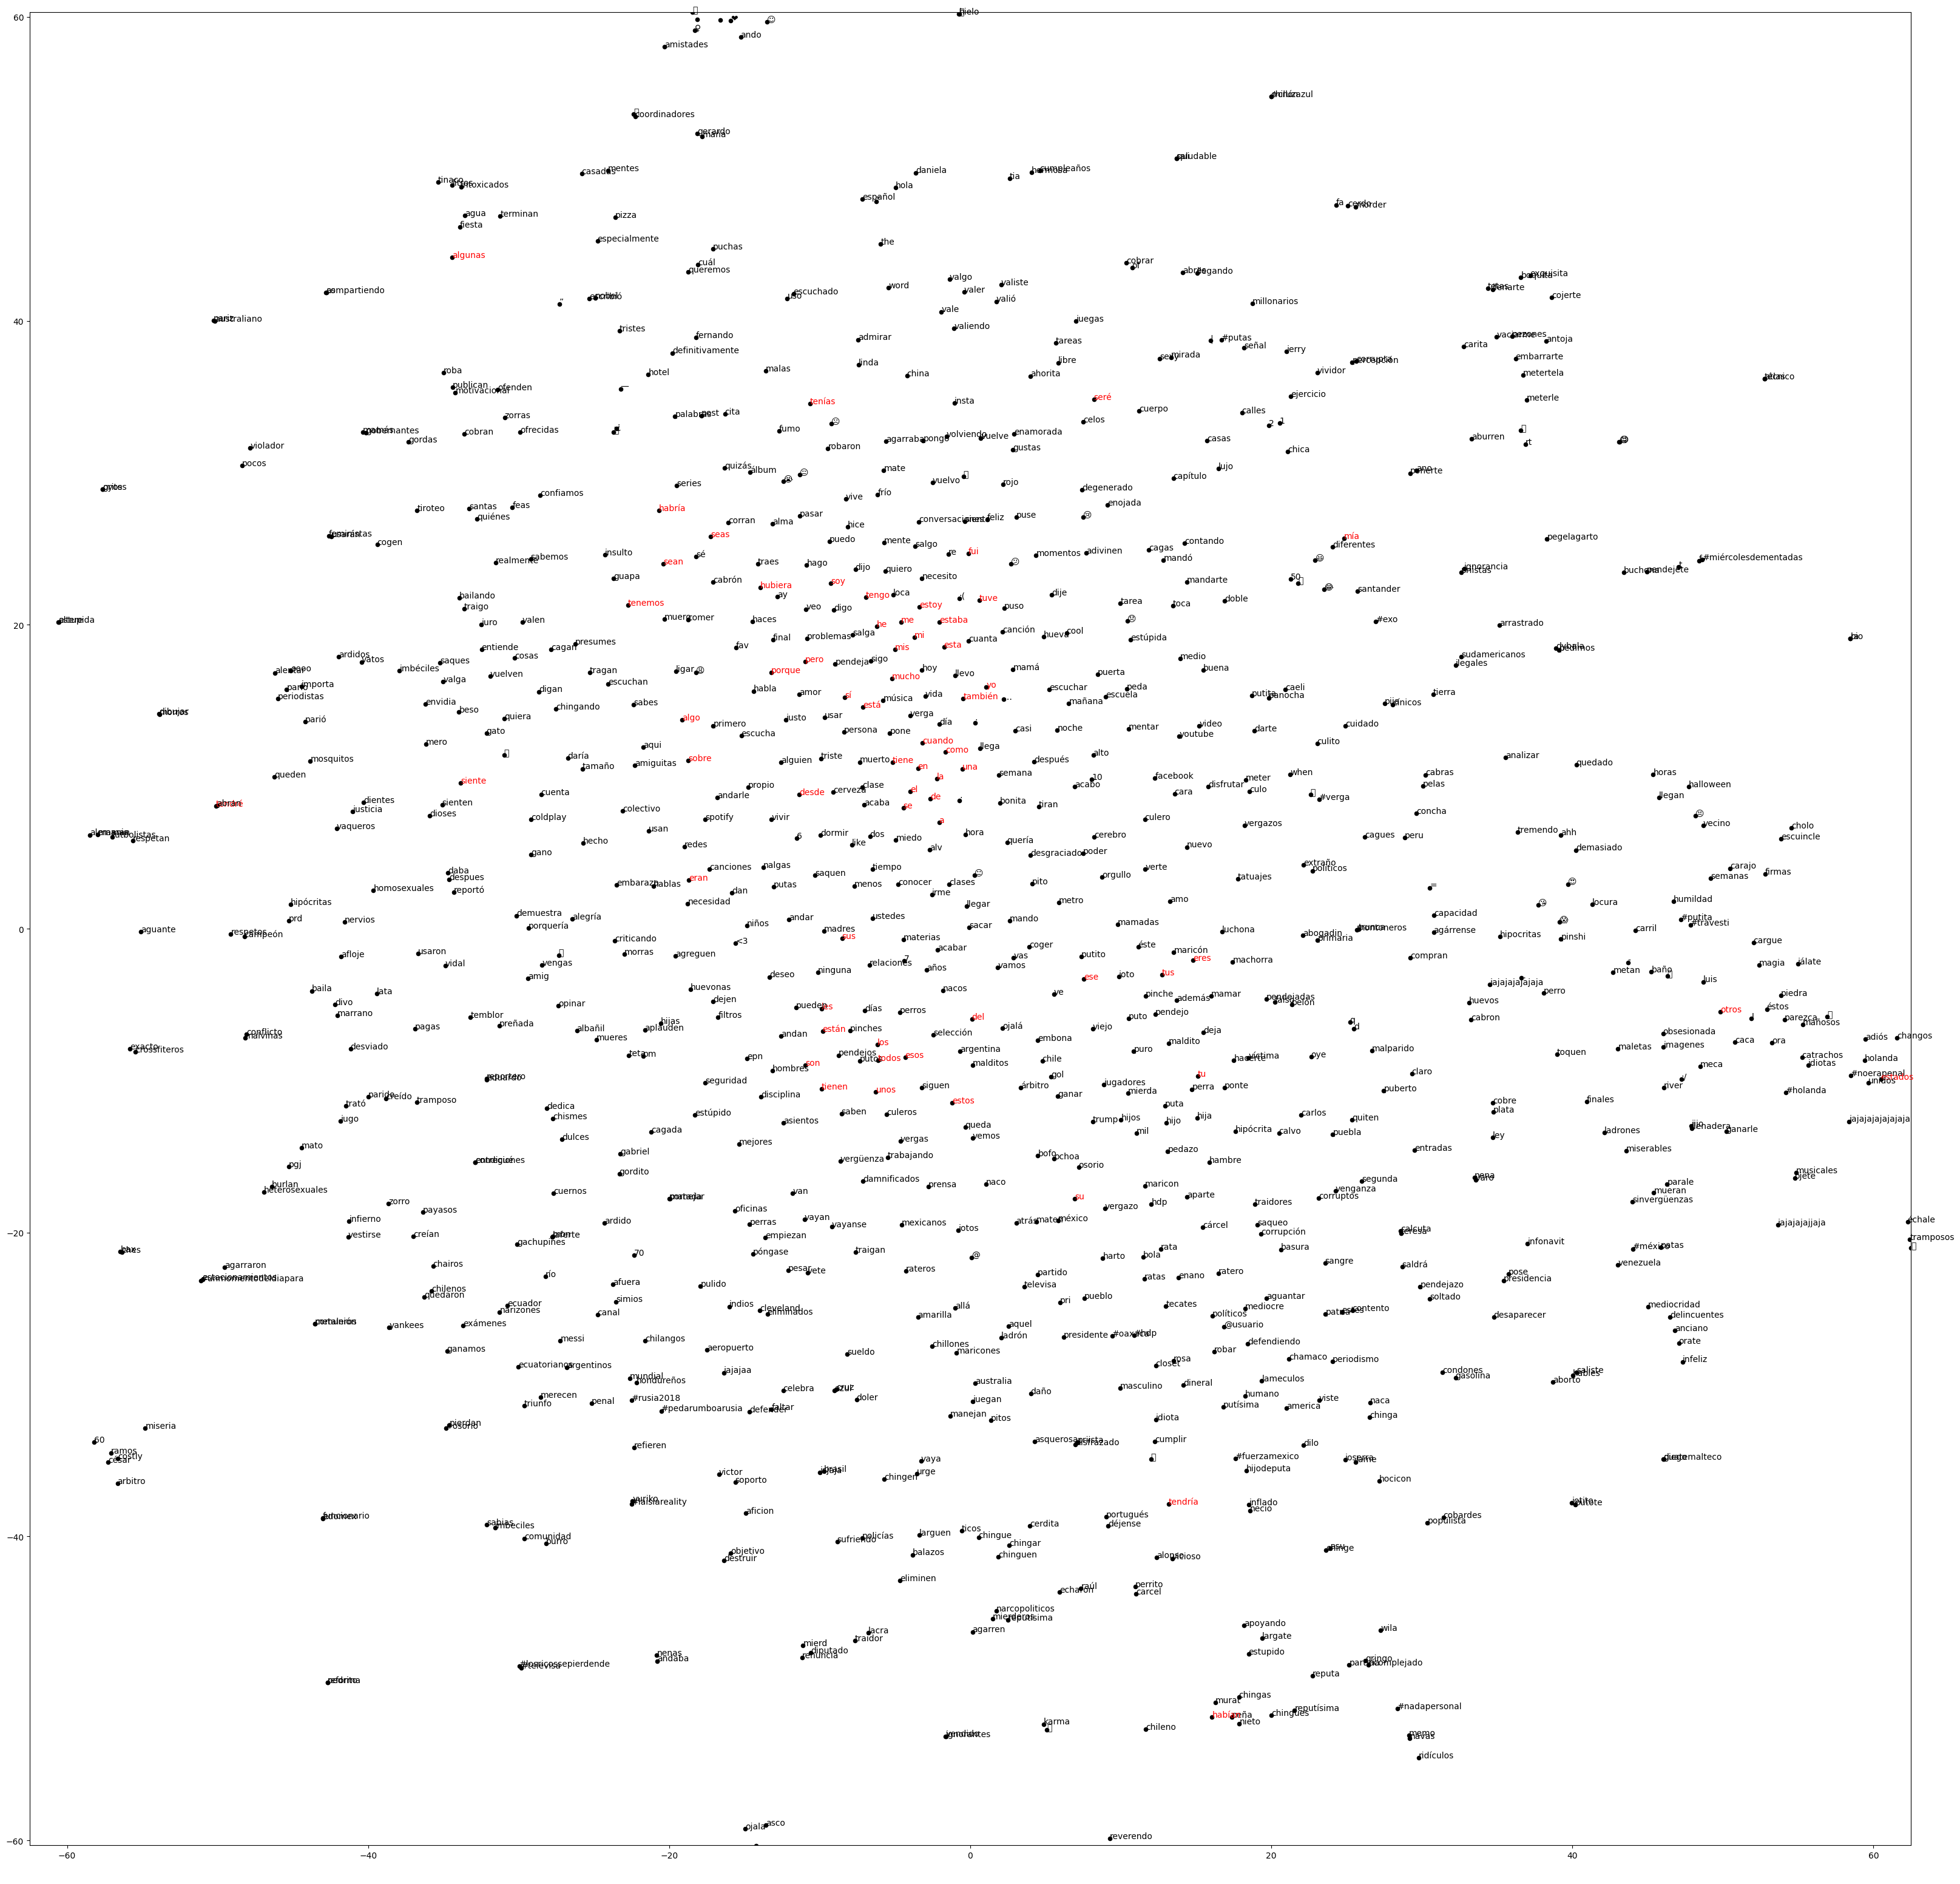

In [ ]:
grafica_constelacion(reduced_matrix, max_x, max_y, t_words)

In [ ]:
subsetwords = ["tristes", "triste", "alegría", "hermosa", "chica", "hombres", "hdp", "madre","madres", "@usuario", "hijos", "pendeja", "pendejo", "mierda", "loca", "hijo", "hija", "mamá", "tía" ]

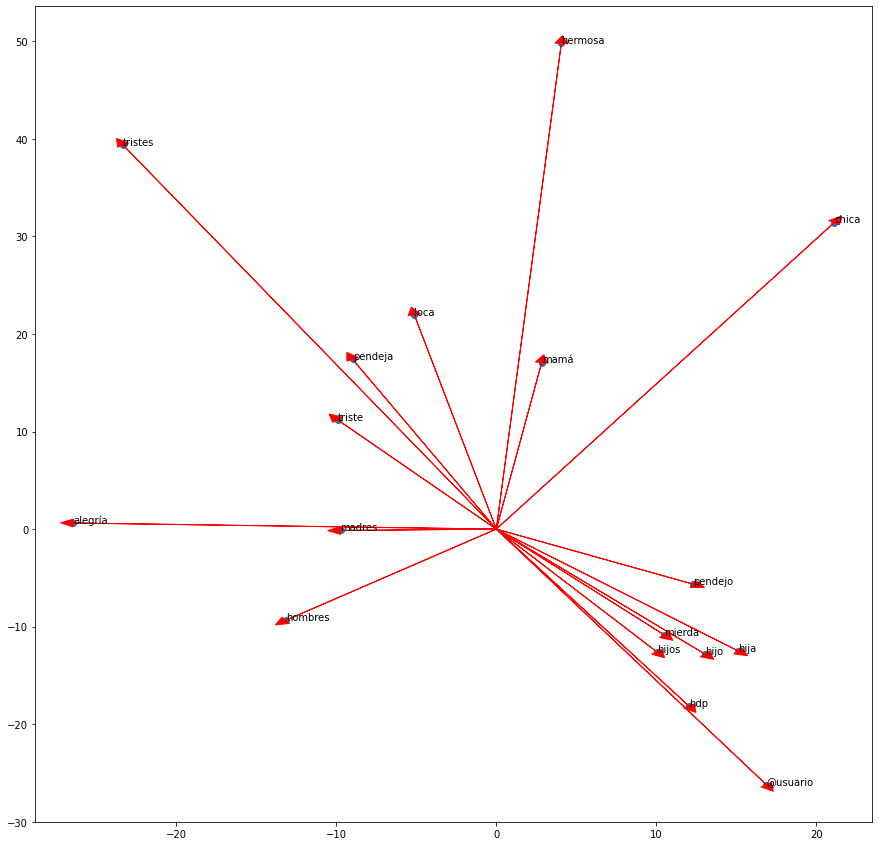

In [ ]:
grafica_centroide(reduced_matrix, t_words, subsetwords)

4. Use alguna de las DTRs anteriores por separado de alguna forma para clasificación de documentos. Compárelas contra un BoW-TFIDF de 5000 palabras más frecuentes y discuta brevemente sus observaciones.

In [ ]:
def tcor_to_BoW (tr_txt, V, dict_indices, tcor_matrix) :
  # Obtengo conjunto de tokens por documento
  sets = [set(tokenizer.tokenize(doc)) for doc in tr_txt]
  # Quito palabras que no están en vocabulario
  for myset in sets :
    tmp = myset.copy()
    for word in tmp :
      if word not in dict_indices:
        myset.remove(word)
  # --------------------------------------------------------
  BoW = np.zeros((len(tr_txt), len(V)), dtype = np.float)
  i = 0
  for subset in sets :
    n = 0.0
    for word in subset :
      BoW[i] += tcor_matrix[dict_indices[word]]
      n += 1.0
    BoW[i] = BoW[i]/n
    i += 1
    
  return BoW

In [ ]:
results = []

In [ ]:
tcor_matrix_tr_PPMI  = compute_tcor(val_txt, V, dict_indices, weight='PPMI')
BoW_TCOR_tr_PPMI     = tcor_to_BoW(tr_txt, V, dict_indices, tcor_matrix_tr_PPMI)
tcor_matrix_val_PPMI = compute_tcor(val_txt, V, dict_indices, weight='PPMI')
BoW_TCOR_val_PPMI    = tcor_to_BoW(val_txt, V, dict_indices, tcor_matrix_val_PPMI)

In [ ]:
print('Training: ', BoW_TCOR_tr_PPMI.shape, 'Testing: ', BoW_TCOR_val_PPMI.shape)

Training:  (5544, 5000) Testing:  (616, 5000)


### BoW TF-IDF

In [ ]:
BOW_tfidf_tr = build_bow_tfidf(tr_txt, V, dict_indices)
BOW_tfidf_tr.shape

(5544, 5000)

In [ ]:
BOW_tfidf_val = build_bow_tfidf(val_txt, V, dict_indices)
BOW_tfidf_val.shape

(616, 5000)

### Clasificación

In [ ]:
results.append(svm_classification(BoW_TCOR_tr_PPMI, tr_y, BoW_TCOR_val_PPMI, val_y))
results.append(svm_classification(BOW_tfidf_tr, tr_y, BOW_tfidf_val, val_y))

[[302  95]
 [ 51 168]]
              precision    recall  f1-score   support

          0
       0.86      0.76      0.81       397
          1
       0.64      0.77      0.70       219

    accuracy                           0.76       616
   macro avg       0.75      0.76      0.75       616
weighted avg       0.78      0.76      0.77       616

[[277 120]
 [ 34 185]]
              precision    recall  f1-score   support

          0
       0.89      0.70      0.78       397
          1
       0.61      0.84      0.71       219

    accuracy                           0.75       616
   macro avg       0.75      0.77      0.74       616
weighted avg       0.79      0.75      0.76       616



In [ ]:
show_results =  [ ['TCOR PPMI'] + results[0], ['TF-IDF'] + results[1]]

In [ ]:
from tabulate import tabulate

print(tabulate(show_results, headers= ['Algorithm','Precision', 'Recall', 'f1 Score']))

Algorithm      Precision    Recall    f1 Score
-----------  -----------  --------  ----------
TCOR PPMI       0.747154  0.763914    0.751214
TF-IDF          0.748616  0.771241    0.744296


5. Bajo la representación TCOR PPMI de los términos, y asumiendo un vocabulario de 5000 palabras, muestre por orden de mayor similitud coseno (ver chp 6 del libro de Dan) los 10 pares de palabras más parecidas en toda la colección.

In [ ]:
def cosine_sim(TCOR_matrix) :
  TCOR_matrix = preprocessing.normalize(TCOR_matrix, norm = 'l2')
  distances = []
  for i in range(TCOR_matrix.shape[0]) :
    pairs = range(i+1,TCOR_matrix.shape[0])
    for j in pairs :
      distance = np.dot(TCOR_matrix[i], TCOR_matrix[j])
      distances.append([distance, i, j])
  distances.sort(reverse = True)
  
  return np.array(distances)

In [ ]:
def show_top_words(distances, dict_indice_invertido, top = 50) :
  for i in range(top) :
    print(i+1,' Cosine: ', distances[i][0], ': (', dict_indice_invertido[round(distances[i][1])], ',',dict_indice_invertido[round(distances[i][2])],') ')

In [ ]:
distances = cosine_sim(tcor_matrix_tr_PPMI)

In [ ]:
show_top_words(distances, dict_indice_invertido, top = 50)

1  Cosine:  1.0000000000000004 : ( juntas , zorras ) 
2  Cosine:  1.0000000000000004 : ( fiesta , zorras ) 
3  Cosine:  1.0000000000000004 : ( fiesta , juntas ) 
4  Cosine:  1.0000000000000004 : ( pasado , zorras ) 
5  Cosine:  1.0000000000000004 : ( pasado , juntas ) 
6  Cosine:  1.0000000000000004 : ( pasado , fiesta ) 
7  Cosine:  1.0000000000000002 : ( hablamos , gonzález ) 
8  Cosine:  1.0000000000000002 : ( hot , hacían ) 
9  Cosine:  1.0000000000000002 : ( seres , encuentra ) 
10  Cosine:  1.0000000000000002 : ( tigre , encuentra ) 
11  Cosine:  1.0000000000000002 : ( tigre , seres ) 
12  Cosine:  1.0000000000000002 : ( aeropuerto , viaje ) 
13  Cosine:  1.0000000000000002 : ( cogido , viejito ) 
14  Cosine:  1.0000000000000002 : ( información , compañera ) 
15  Cosine:  1.0000000000000002 : ( robó , hubieran ) 
16  Cosine:  1.0000000000000002 : ( suficientemente , notas ) 
17  Cosine:  1.0000000000000002 : ( taxi , viaje ) 
18  Cosine:  1.0000000000000002 : ( taxi , aeropuerto 

6. Bajo la representación BoW-TFIDF de los documentos, y asumiendo un vocabulario de
5000 palabras, muestre en por orden de más similitud coseno (ver chp 6 del libro de Dan) los 10 pares de documentos más parecidos en toda la colección. Muestre el texto que contienen y muestre la categoría de cada uno. Elabore máximo 5 renglones de discusión.

In [ ]:
distances = cosine_sim(BOW_tfidf_tr)

In [ ]:
def show_top_documents(distances, top = 50, category = tr_y) :
  for i in range(top) :
    print(i+1,'Cosine: ', distances[i][0], ': (', round(distances[i][1]), ',', round(distances[i][2]), ')')
    print('Category :', tr_y[round(distances[i][1])], tr_txt[round(distances[i][1])])
    print('Category :', tr_y[round(distances[i][2])], tr_txt[round(distances[i][2])])
    print('# ---------------------------------------------------------------------------------------------')

In [ ]:
show_top_documents(distances, top = 10, category = tr_y)

1 Cosine:  1.0 : ( 2720 , 4152 )
Category : 0 una flaquita tetona recibe su dotación mientras chupa otra verga! ¡mira su cara de placer! rt para más vídeos

Category : 0 una flaquita tetona recibe su dotación mientras chupa otra verga! ¡mira su cara de placer!  rt para más vídeos

# ---------------------------------------------------------------------------------------------
2 Cosine:  0.9956461610366206 : ( 3693 , 5227 )
Category : 0 quiero un pasivo que se ensarte mi verga así 🔥🔥como @usuario cabalga la verga de  @veguerovzla

Category : 0 quiero un pasivo que se ensarte mi verga así 🔥🔥como @usuario cabalga la verga de  @usuario

# ---------------------------------------------------------------------------------------------
3 Cosine:  0.9849145538124163 : ( 4489 , 5413 )
Category : 0 me estaba valiendo madre el mundo hasta que llegaste tú.

Category : 0 me estaba valiendo verga el mundo hasta que llegaste tú.

# ------------------------------------------------------------------------

## Discusión

Los resultados obtenidos tienen sentido, ya que los twitts son muy parecidos, de hecho el texto es casi igual en todos ellos. Lo que lleva a pensar que el corpus no está bien filtrado dado que el contenido es similar o que fue intensional para agregar ruido al conjunto. 

También podría ser que los twitts corresponden a textos spam o a texto generado por boots.  Observemos que el el texto 4 es extraño encontrar que el mismo texto se clasifique tanto como no agresivo como agresivo. Parece que la diferencia entre los textos es sitil pero para este pesado pero el valor del coseno es casi uno para todos estos documentos de manera natural.

Por ejemplo, para el primer texto es normal que el coseno sea uno ya que la única diferencia es un espacio hacia el final.

7. Use Mutual Information como lo sugiere Baeza-Yates para descubrir el top 50 de las palabras más relevantes para los twitteros agresivos. Haga una gráfica usando los valores de importancia de las palabras para determinar su tamaño con la siguiente herramienta:

https://amueller.github.io/word_cloud/

In [ ]:
from wordcloud import WordCloud

In [ ]:
# Funciones para top de palabras
def get_nip_dic(BoW, tr_y, clases):
  local_dict = {}
  tr_y = np.array(tr_y)
  for c in clases:
    # Posiciones de la clase
    yes = tr_y == c
    docs_c = BoW[yes, :]
    ans[c] = np.sum(docs_c > 0, axis=0)
  return local_dict

In [ ]:
def mutual_information(BoW, tr_y, dict_indices):
  # Número de documentos
  N_t = BoW.shape[0]
  # Documentos con término k_i
  n_i = np.sum(BoW > 0, axis=0)
  # Total de Documentos por clase
  n_p = nltk.FreqDist(tr_y)
  clases = n_p.keys()
  # Documentos que contienen término k_i y pertenecen a la clase cp
  n_ip = get_nip_dic(BoW, tr_y, clases)

  mi_0 = np.zeros(BoW.shape[1], dtype=float)
  mi_1 = np.zeros(BoW.shape[1], dtype=float)

  # Clase 0
  p1 = n_p[0] / N_t
  p2 = N_t * n_ip[0] / (n_i * n_p[0])
  p2[p2 == 0] = 1.0 # Corrección logaritmo
  mi_0 = p1 * np.log(p2)
  # Clase 1
  p1 = n_p[1] / N_t
  p2 = N_t * n_ip[1] / (n_i * n_p[1])
  p2[p2 == 0] = 1.0 # Corrección logaritmo
  mi_1 = p1 * np.log(p2)

  # Creo diccionario palabra-valor
  mi_dict_0 = {word: mi_0[index] for word, index in dict_indices.items()}
  mi_dict_1 = {word: mi_1[index] for word, index in dict_indices.items()}

  return mi_dict_0, mi_dict_1

In [ ]:
mi_0, mi_1 = mutual_information(BOW_tr, tr_y, dict_indices)

In [ ]:
srtd = sorted(mi_1.items(), key=lambda item: item[1], reverse=True)
for key, value in srtd[:50]:
    print(key, value)

lameculos 0.3677265174879372
bola 0.3677265174879372
rateros 0.3677265174879372
corruptos 0.3677265174879372
mediocre 0.3677265174879372
chilenos 0.3677265174879372
holanda 0.3677265174879372
simios 0.3677265174879372
pedazo 0.3677265174879372
reputa 0.3677265174879372
pario 0.3677265174879372
nacos 0.3677265174879372
miserables 0.3677265174879372
zorras 0.3677265174879372
ratero 0.3677265174879372
primaria 0.3677265174879372
60 0.3677265174879372
traidores 0.3677265174879372
santas 0.3677265174879372
rosa 0.3677265174879372
robaron 0.3677265174879372
priistas 0.3677265174879372
merecen 0.3677265174879372
lame 0.3677265174879372
juegan 0.3677265174879372
imbéciles 0.3677265174879372
humano 0.3677265174879372
culito 0.3677265174879372
carlos 0.3677265174879372
asquerosa 0.3677265174879372
#rusia2018 0.3677265174879372
#méxico 0.3677265174879372
éstos 0.3677265174879372
yankees 0.3677265174879372
vengas 0.3677265174879372
traidor 0.3677265174879372
ticos 0.3677265174879372
respetan 0.367

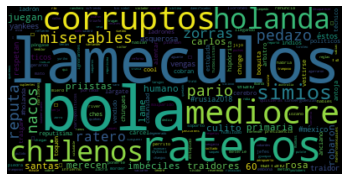

In [ ]:
wc = WordCloud()
wc.generate_from_frequencies(mi_1)
plt.axis("off")
plt.imshow(wc, interpolation ="bilinear")
plt.show()

8. Use Mutual Information para descubrir el top 50 de las palabras más relevantes para los twitteros NO agresivos. Haga una gráfica también con la herramienta de word_cloud.

In [ ]:
srtd = sorted(mi_1.items(), key=lambda item: item[1], reverse=True)
for key, value in srtd[:50]:
    print(key, value)

lameculos 0.3677265174879372
bola 0.3677265174879372
rateros 0.3677265174879372
corruptos 0.3677265174879372
mediocre 0.3677265174879372
chilenos 0.3677265174879372
holanda 0.3677265174879372
simios 0.3677265174879372
pedazo 0.3677265174879372
reputa 0.3677265174879372
pario 0.3677265174879372
nacos 0.3677265174879372
miserables 0.3677265174879372
zorras 0.3677265174879372
ratero 0.3677265174879372
primaria 0.3677265174879372
60 0.3677265174879372
traidores 0.3677265174879372
santas 0.3677265174879372
rosa 0.3677265174879372
robaron 0.3677265174879372
priistas 0.3677265174879372
merecen 0.3677265174879372
lame 0.3677265174879372
juegan 0.3677265174879372
imbéciles 0.3677265174879372
humano 0.3677265174879372
culito 0.3677265174879372
carlos 0.3677265174879372
asquerosa 0.3677265174879372
#rusia2018 0.3677265174879372
#méxico 0.3677265174879372
éstos 0.3677265174879372
yankees 0.3677265174879372
vengas 0.3677265174879372
traidor 0.3677265174879372
ticos 0.3677265174879372
respetan 0.367

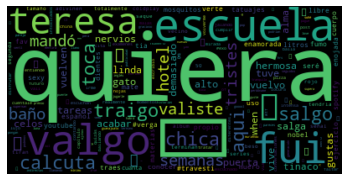

In [ ]:
wc = WordCloud()
wc.generate_from_frequencies(mi_0)
plt.axis("off")
plt.imshow(wc, interpolation = "bilinear")
plt.show()

9. Use Ganancia de Información como lo sugiere Baeza-Yates para descubrir el top 50 de las palabras más relevantes de TODA la colección. Haga una gráfica también con la herramienta de word_cloud.

In [ ]:
def information_gain(BoW, tr_y, dict_indices):
  # Número de documentos
  N_t = BoW.shape[0]
  # Documentos con término k_i
  n_i = np.sum(BoW > 0, axis=0)
  # Total de Documentos por clase
  n_p = nltk.FreqDist(tr_y)
  clases = n_p.keys()
  # Documentos que contienen término k_i y pertenecen a la clase cp
  n_ip = get_nip_dic(BoW, tr_y, clases)

  ig = np.zeros(BoW.shape[1], dtype=np.float)

  for c in clases:
    # Corrección logaritmos
    nip_zeros = n_ip[c] == 0
    n_ip[c][nip_zeros] = 1

    t_1 = (n_p[c] / N_t) * np.log(n_p[c] / N_t)
    t_2 = - (n_ip[c] / N_t) * np.log(n_ip[c] / n_i)
    t_3 = - (n_p[c] - n_ip[c]) / N_t * np.log((n_p[c] - n_ip[c]) / (N_t - n_i))

    ig -= t_1 + t_2 + t_3

  # Creo diccionario palabra-valor
  ig_dict = {word: ig[index] for word, index in dict_indices.items() }

  return ig_dict

In [ ]:
ig = information_gain(BOW_tr, tr_y, dict_indices)

In [ ]:
srtd = sorted(ig.items(), key=lambda item: item[1], reverse=True)

for key, value in srtd[:50]:
    print(key, value)

loca 0.0368331163379223
hdp 0.031026737364846846
@usuario 0.023511312501166587
putos 0.015111660042345237
me 0.011372628432905041
tu 0.008998743664222875
hijos 0.007680496066623577
pendejo 0.007589257522377102
estoy 0.007216197372012401
puto 0.007142263023866946
son 0.007093369342250133
mamar 0.006735751674884327
puta 0.006686919391608814
chinguen 0.0065193430669978625
pendejos 0.006403397448023818
mierda 0.006219052132613034
hijo 0.006021847583927209
mi 0.00567430289012516
verga 0.005621036605887669
pinche 0.005336890375027492
los 0.0050476752070290065
chinga 0.004245743206922725
chingas 0.004208035472698324
pinches 0.0040646488491493105
su 0.0039958552545634185
esos 0.0038410702346720615
mundial 0.003777252449205404
vida 0.0037643120317549794
a 0.003751407282850533
chingar 0.0037238981664117765
… 0.0036956353044768075
hondureños 0.0036141733627604866
mil 0.0033480346821804785
lameculos 0.0032606818865030807
bola 0.003082680267589566
esta 0.003055031092135174
❤ 0.002922219384647262
gr

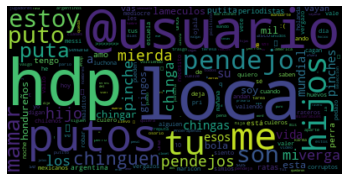

In [ ]:
wc = WordCloud()
wc.generate_from_frequencies(ig)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

10. Use Chi2 como lo sugiere Baeza-Yates para descubrir el top 50 de las palabras más
relevantes de TODA la colección. Haga una gráfica también con la herramienta de
word_cloud.

In [ ]:
def chi_2(BoW, tr_y, dict_indices, average = True):
  # Número de documentos
  N_t = BoW.shape[0]
  # Documentos con término k_i
  n_i = np.sum(BoW > 0, axis=0)
  # Total de Documentos por clase
  n_p = nltk.FreqDist(tr_y)
  clases = n_p.keys()
  # Documentos que contienen término k_i y pertenecen a la clase cp
  n_ip = get_nip_dic(BoW, tr_y, clases)

  chi2 = np.zeros(BoW.shape[1], dtype = np.float)

  for c in clases:
    # Calcula chi actual
    num =  N_t * (N_t * n_ip[c] - n_p[c] * n_i) * (N_t * n_ip[c] - n_p[c] * n_i)
    den = n_p[c] * n_i * (N_t - n_p[c]) * (N_t - n_i)
    chi_ip = num/den
    if average:
      # Usa promedio
      chi2 += n_p[c] / N_t * chi_ip
    else:
      # Usar máximo
      chi2 = np.maximum(chi2, chi_ip)

  # Creo diccionario palabra-valor
  chi = {word: chi2[index] for word, index in dict_indices.items() }

  return chi

In [ ]:
c2 = chi_2(BOW_tr, tr_y, dict_indices)

In [ ]:
srtd = sorted(c2.items(), key=lambda item: item[1], reverse=True)

for key, value in srtd[:50]:
    print(key, value)

hdp 336.69401097560456
loca 295.2386194185803
@usuario 272.1481850282203
putos 174.7217140925539
me 119.88163428515487
tu 104.71732142981111
hijos 88.56707172056656
pendejo 87.44242165153156
puto 83.41375551494644
son 83.02306642812069
puta 78.18483780061447
mamar 74.85513166338919
mierda 72.63874214801473
pendejos 71.31182034986493
hijo 69.9488870057805
chinguen 66.93811319012319
estoy 66.75077613058878
pinche 62.24200488497057
verga 59.83826066163522
mi 58.85885712638901
los 57.758345237075716
chingas 48.47039698704949
chinga 47.77240668085909
pinches 47.605294773912334
su 45.98130735775021
esos 44.97511104856727
mundial 43.848041036299634
chingar 43.11036189191458
a 41.93814941882229
mil 38.7830231189253
hondureños 37.914477309791096
lameculos 37.913931397707884
bola 36.10196943373343
… 35.7839612179058
vida 35.31465543776035
putita 31.87849445166902
gringos 30.70304859816075
vas 30.458832378977387
esta 30.234180638025457
soy 27.145222420700236
vayan 25.741162237421833
perra 25.5182

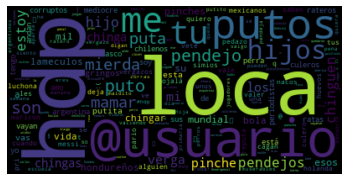

In [ ]:
wc = WordCloud()
wc.generate_from_frequencies(c2)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()